Monitoramento e Fairness

In [55]:
import pandas as pd 
import joblib
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

Carregar modelo e vetor já treinados

In [56]:
modelo_path = '../model.joblib'
vetor_path = '../vectorizer.joblib'
dados_path = '../data/tweets_limpo.csv'

if not (os.path.exists(modelo_path) and os.path.exists(vetor_path)):
    raise FileExistsError('Treine e salve o modelo antes de executar!')

model = joblib.load(modelo_path)
vectorizer = joblib.load(vetor_path)
df = pd.read_csv(dados_path)
display(df.head())

,text,label,text_length
0,Adorei o produto de investimentos no mercado d...,positivo,56
1,O serviço de instalação internet doi péssimo. ...,negativo,59
2,Foi ok,neutro,6
3,Entrega rápida com atendimento excelente,positivo,40
4,Não voltarei a comprar,negativo,22


Monitoramento

In [57]:
novos_textos = [
'Muito ruim, não gostei do atendimento.',
'A entrega foi sensacional!',
'Não funcionou, me decepcionei.',
'Recomendo para todos, nota 10!',
'Recomendo para todos, top!',
"O produto chegou conforme esperado."
]

novos_df = pd.DataFrame({'text': novos_textos})
display(novos_df)

,text
0,"Muito ruim, não gostei do atendimento."
1,A entrega foi sensacional!
2,"Não funcionou, me decepcionei."
3,"Recomendo para todos, nota 10!"
4,"Recomendo para todos, top!"
5,O produto chegou conforme esperado.


Vetorizar e predição

In [58]:
novos_vetores = vectorizer.transform(novos_df['text'])
novos_preds = model.predict(novos_vetores)
novos_df['sentimento_predito'] = novos_preds
print(novos_df)

                                     text sentimento_predito
0  Muito ruim, não gostei do atendimento.           negativo
1              A entrega foi sensacional!             neutro
2          Não funcionou, me decepcionei.           negativo
3          Recomendo para todos, nota 10!           negativo
4              Recomendo para todos, top!           negativo
5     O produto chegou conforme esperado.             neutro


Porcentagem de cada classe

In [59]:
class_dist = novos_df['sentimento_predito'].value_counts(normalize=True)
print('Distribuição dos sentimentos preditos no novos dados:')
print(class_dist)

Distribuição dos sentimentos preditos no novos dados:
sentimento_predito
negativo    0.666667
neutro      0.333333
Name: proportion, dtype: float64


Fairness - Vieses

In [60]:
df['text_len'] = df['text'].apply(len)
df['len_category'] = pd.cut(df['text_len'], bins=[0,50,150,1000], labels=['curto', 'medio', 'longo'])
display(df['len_category'])


0     medio
1     medio
2     curto
3     curto
4     curto
5     curto
6     curto
7     curto
8     curto
9     curto
10    curto
11    curto
12    curto
13    curto
14    curto
15    curto
16    curto
17    curto
18    curto
19    curto
20    curto
21    curto
22    curto
23    curto
24    curto
25    curto
26    longo
27    longo
28    longo
29    longo
30    longo
31    longo
32    longo
33    longo
34    longo
Name: len_category, dtype: category
Categories (3, object): ['curto' < 'medio' < 'longo']

Predições conjunto de validação

In [61]:
vetores = vectorizer.transform(df['text'])
df['pred'] = model.predict(vetores)
display(df['pred'])

0     positivo
1     negativo
2       neutro
3     positivo
4     negativo
5     positivo
6     negativo
7     positivo
8     negativo
9     positivo
10    negativo
11    positivo
12    negativo
13    positivo
14    positivo
15    positivo
16    negativo
17      neutro
18      neutro
19    negativo
20      neutro
21      neutro
22      neutro
23      neutro
24      neutro
25      neutro
26    positivo
27    negativo
28      neutro
29      neutro
30      neutro
31    positivo
32    negativo
33      neutro
34    positivo
Name: pred, dtype: object

Avaliação de acurácia

In [62]:
for cat in df['len_category'].unique():
    subset = df[df['len_category'] == cat]
    if not subset.empty:
        acuracia = (subset['label'] == subset['pred']).mean()
        print(f'Acurácia para os textos {cat}: {acuracia:.2f} (N={len(subset)})')

Acurácia para os textos medio: 1.00 (N=2)
Acurácia para os textos curto: 0.96 (N=24)
Acurácia para os textos longo: 0.89 (N=9)


Desafio fairness


Matriz de confusão para textos medio:
[[1 0]
 [0 1]]


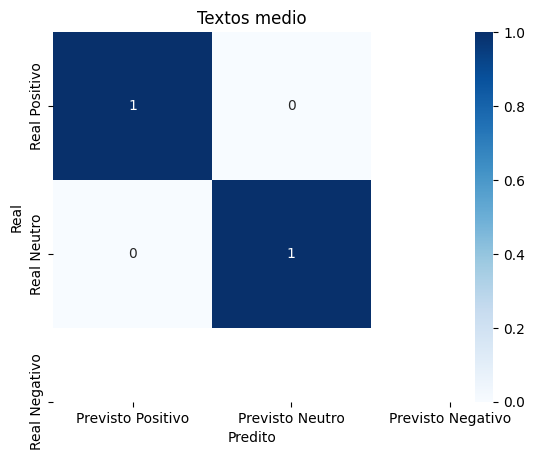


Matriz de confusão para textos curto:
[[6 0 0]
 [1 9 0]
 [0 0 8]]


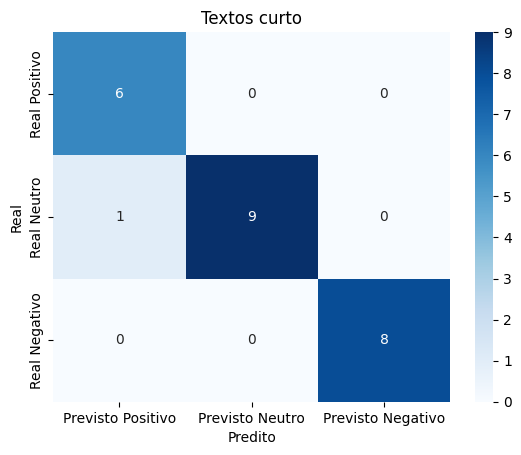


Matriz de confusão para textos longo:
[[2 1 0]
 [0 3 0]
 [0 0 3]]


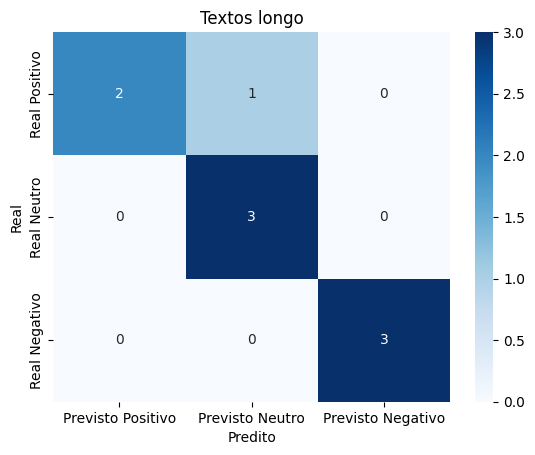

In [63]:
for cat in df['len_category'].unique():
    subset = df[df['len_category'] == cat]
    if not subset.empty:
        print(f'\nMatriz de confusão para textos {cat}:')
        print(confusion_matrix(subset['label'], subset["pred"]))
        sns.heatmap(confusion_matrix(subset['label'], subset["pred"]),
                    annot=True, fmt='d', cmap='Blues',
                     xticklabels=["Previsto Positivo", "Previsto Neutro", "Previsto Negativo"],
                    yticklabels=["Real Positivo", "Real Neutro", "Real Negativo"])
        plt.title(f'Textos {cat}')
        plt.xlabel('Predito')
        plt.ylabel('Real')
        plt.show()